# Epymix integration

This tutorial demonstrate how an existing openalea model (epymix) can be exported as an IPM-compliant web service

## Get Epymix factory from OpenAlea package manager

In [1]:
from openalea.core.pkgmanager import PackageManager
pm = PackageManager()
pm.init()

In [2]:
factory = pm['ipmdecisions.epymix']['epymix_seir']
node = factory.instantiate()

In [3]:
[v['name'] for v in node.input_desc], node.output_desc

(['sowing_date',
  'daily_tmin',
  'daily_tmax',
  'daily_rain',
  'delta_t',
  'rainfall_threshold',
  'scenario_ino',
  'Lx',
  'Ly',
  'Lr',
  'frac_inf',
  'inoc_init_abs',
  'ng_ext0_abs',
  'scenario_rot',
  'wheat_fraction',
  'day_length',
  'alpha_ure',
  'radius_ure',
  'alpha_asco',
  'radius_asco',
  'alpha_pycnid',
  'radius_pycnid',
  't',
  'season',
  'mu_companion',
  'beta_companion',
  'end_companion',
  'LAI_K',
  'delta_companion',
  'disease',
  'mu_wheat',
  'nu',
  'beta_wheat',
  'end_wheat',
  'ber_wheat',
  'ber_companion',
  'h_wheat',
  'h_companion',
  'lambd',
  'delta_ei',
  's0',
  'pi_inf0',
  'rho',
  'psi',
  'gamma',
  'theta',
  'sigma',
  'sigma_asco',
  'inf_begin'],
 [{'name': 'Nsp', 'interface': 'ISequence'},
  {'name': 'Pth', 'interface': 'ISequence'},
  {'name': 'Poi', 'interface': 'ISequence'},
  {'name': 'Sth', 'interface': 'ISequence'},
  {'name': 'Sus', 'interface': 'ISequence'},
  {'name': 'Lat', 'interface': 'ISequence'},
  {'name': 'If

In [4]:
factory.get_id(), factory.get_authors()

('epymix_SEIR',
 'Sebastien Levionnois, Christophe Pradal, ... (wralea authors)')

In [5]:
factory.get_node_file().replace('\\','/')

'c:/users/fourniec/develop/ipm/epymix/src/epymix/wralea/adaptor.py'

## Create IPM model

In [6]:
from openalea.dss.dss_factory import dss_factory
help(dss_factory)

Help on function dss_factory in module openalea.dss.dss_factory:

dss_factory(model_id, node, factory=None, interval=86400, weather_parameters=None, config_params=None, decision_support=None, meta=None)
    Transform an openalea node in a IPM model json descriptor and generate a fastAPI script to launch webservice
    
    Args:
        node: the node to be exported
        factory
    
        : the node factory associated to the node (optional)
        interval: the time step of the model (s)
        weather_parameters: a mapping between node input name and weather data codes, if any.
        None if none of the input is a weather data
        parameters: a list of node input name to be exposed as config parameters in IPM-Decison platform
        meta : model meta informations
    Returns:
        model: a json-like dict describing the model
        dss_service: a string containing the script to be run for launching the web service



In [7]:
input_mapping = {'weather_parameters': {"daily_tmin": 1003, "daily_tmax": 1004, "daily_rain": 2001},
                 'config_params': ["sowing_date", "delta_t", "rainfall_threshold", "scenario_ino", "Lx", "Ly", "Lr", "frac_inf", "inoc_init_abs", "ng_ext0_abs", "scenario_rot", "wheat_fraction"]}
ipm_model, service = dss_factory('epymix', node, factory=factory,**input_mapping)

In [8]:
ipm_model

{'id': 'epymix',
 'name': 'Sample model',
 'version': '0.0.0',
 'purpose': 'Sample meta informations generated by openalea dss facctory',
 'description': 'Please provide here a concise description of the model',
 'type_of_decision': 'Short-term tactical',
 'type_of_output': 'Risk indication',
 'description_url': None,
 'citation': None,
 'keywords': None,
 'platform_validated': False,
 'pests': [],
 'crops': [],
 'authors': [{'name': 'Anonymous',
   'email': 'anonymous@mail',
   'organization': 'Unknown'}],
 'valid_spatial': {'countries': [], 'geoJSON': '{}'},
 'execution': {'type': 'ONTHEFLY',
  'endpoint': 'http://127.0.0.1:8000/epymix/',
  'form_method': 'post',
  'content_type': 'application/json',
  'input_schema_categories': {'hidden': ['modelId'],
   'system': [],
   'user_init': [],
   'triggered': [],
   'internal': []},
  'input_schema': {'type': 'object',
   'properties': {'configParameters': {'title': 'Configuration parameters',
     'type': 'object',
     'properties': {'t

In [9]:
print(service)

from __future__ import annotations

from typing import List

from pydantic import BaseModel


class ConfigParameters(BaseModel):
    timeZone: str
    timeStart: str
    timeEnd: str
    sowing_date: str
    delta_t: int
    rainfall_threshold: int
    scenario_ino: str
    Lx: int
    Ly: int
    Lr: int
    frac_inf: int
    inoc_init_abs: int
    ng_ext0_abs: int
    scenario_rot: str
    wheat_fraction: float


class LocationWeatherDatum(BaseModel):
    longitude: float
    latitude: float
    altitude: float
    data: List[List[float]]
    length: int
    width: int


class WeatherData(BaseModel):
    timeStart: str
    timeEnd: str
    interval: int
    weatherParameters: List[int]
    locationWeatherData: List[LocationWeatherDatum]


class PydanticModel(BaseModel):
    modelId: str
    configParameters: ConfigParameters
    weatherData: WeatherData


from fastapi import FastAPI
from openalea.dss.dss_factory import encode_input, encode_output

app = FastAPI()

from openalea.core.

## Launch the Webservice

In [10]:
from openalea.dss.dss_factory import start_service, stop_service

http, handler = start_service(service)

In [11]:
from IPython.display import IFrame

In [12]:
IFrame(http + '/docs', 800,400)

## Test the exported model

In [13]:
import agroservices.ipm.fakers as ipm_fakers
from agroservices.ipm.ipm import IPM

In [14]:
ipm = IPM()
input_data = ipm_fakers.input_data(ipm_model)
input_data

{'configParameters': {'timeZone': 'Europe/Oslo',
  'timeStart': '2023-03-01',
  'timeEnd': '2023-09-01',
  'sowing_date': '2019-09-01',
  'delta_t': 10,
  'rainfall_threshold': 3,
  'scenario_ino': 'initial_inoculum',
  'Lx': 1,
  'Ly': 1,
  'Lr': 1,
  'frac_inf': 1,
  'inoc_init_abs': 20000000,
  'ng_ext0_abs': 20000,
  'scenario_rot': 'uniform',
  'wheat_fraction': 0.5},
 'modelId': 'epymix',
 'weatherData': {'weatherParameters': [1003, 1004, 2001],
  'timeStart': '2023-03-01T00:00:00+01:00',
  'timeEnd': '2023-09-01T00:00:00+02:00',
  'interval': 86400,
  'locationWeatherData': [{'longitude': 19.61473141865944,
    'latitude': 64.64383640418903,
    'altitude': 0,
    'data': [[9.8, 1.8, 0.1],
     [6.1, 6.7, 2.1],
     [7.3, 4.7, 9.6],
     [0.5, 4.4, 4.0],
     [9.8, 8.7, 1.0],
     [4.7, 6.5, 1.4],
     [2.5, 5.0, 9.9],
     [4.8, 8.6, 8.1],
     [1.1, 3.4, 8.5],
     [3.5, 1.6, 4.8],
     [8.0, 0.8, 4.6],
     [8.4, 2.1, 9.4],
     [4.1, 0.0, 9.6],
     [4.8, 6.4, 3.7],
     [9.

In [16]:
output = ipm.run_model(ipm_model, input_data)
output

{'timeStart': '2023-03-01T00:00:00+01:00',
 'timeEnd': '2023-09-01T00:00:00+02:00',
 'interval': 86400,
 'resultParameters': ['Nsp',
  'Pth',
  'Poi',
  'Sth',
  'Sus',
  'Lat',
  'Ifc',
  'Ifv',
  'Rem',
  'LAI',
  'LAI_wheat',
  'Poo',
  'Eps',
  'AUDPC',
  'Scont'],
 'locationResult': [{'longitude': 19.61473141865944,
   'latitude': 64.64383640418903,
   'altitude': 0.0,
   'data': [[0.0,
     0.003,
     0.003,
     0.003,
     0.003,
     0.0,
     0.0,
     0.0,
     0.0,
     0.006,
     0.003,
     20000000.0,
     0.005982035946064687,
     0.0,
     0.0],
    [0.0,
     0.00326973,
     0.00326973,
     0.00326973,
     0.00326973,
     0.0,
     0.0,
     0.0,
     0.0,
     0.00653946,
     0.00326973,
     19960000.0,
     0.00651812426485021,
     0.0,
     0.0],
    [19409714.285714287,
     0.003563684965971813,
     0.003563684965971813,
     0.003563684965971813,
     0.002514559908000322,
     0.0010491250579714908,
     0.0,
     0.0,
     0.0,
     0.00712736993194

In [18]:
import pandas
df = pandas.DataFrame(dict(zip(output['resultParameters'],zip(*output['locationResult'][0]['data']))))
df

,Nsp,Pth,Poi,Sth,Sus,Lat,Ifc,Ifv,Rem,LAI,LAI_wheat,Poo,Eps,AUDPC,Scont
0,0.000000e+00,0.003000,0.003000,0.003000,0.003000,0.000000,0.000000,0.000000,0.000000,0.006000,0.003000,2.000000e+07,0.005982,0.000000,0.000000
1,0.000000e+00,0.003270,0.003270,0.003270,0.003270,0.000000,0.000000,0.000000,0.000000,0.006539,0.003270,1.996000e+07,0.006518,0.000000,0.000000
2,1.940971e+07,0.003564,0.003564,0.003564,0.002515,0.001049,0.000000,0.000000,0.000000,0.007127,0.003564,1.994005e+07,0.007102,0.000000,0.001049
3,1.908548e+07,0.003884,0.003884,0.003884,0.002039,0.001845,0.000000,0.000000,0.000000,0.007768,0.003884,1.990015e+07,0.007738,0.000000,0.000796
4,1.878300e+07,0.004233,0.004233,0.004233,0.001752,0.002481,0.000000,0.000000,0.000000,0.008466,0.004233,1.988032e+07,0.008431,0.000000,0.000637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.000000e+00,2.988344,0.118368,0.118368,0.048960,0.003972,0.045699,0.923139,2.893200,5.980175,2.991831,1.171566e+08,0.195070,122.612184,0.000000
246,4.112934e+05,2.988344,0.114817,0.114817,0.047131,0.003944,0.044601,0.923412,2.896158,5.980177,2.991833,1.173336e+08,0.189815,123.535596,0.000361
247,0.000000e+00,2.988344,0.111372,0.111372,0.045717,0.003570,0.043511,0.923660,2.899017,5.980158,2.991814,1.170989e+08,0.184676,124.459256,0.000000
248,3.915984e+05,2.988344,0.108031,0.108031,0.044022,0.003542,0.042451,0.923906,2.901800,5.980159,2.991816,1.172563e+08,0.179669,125.383162,0.000323


<Axes: >

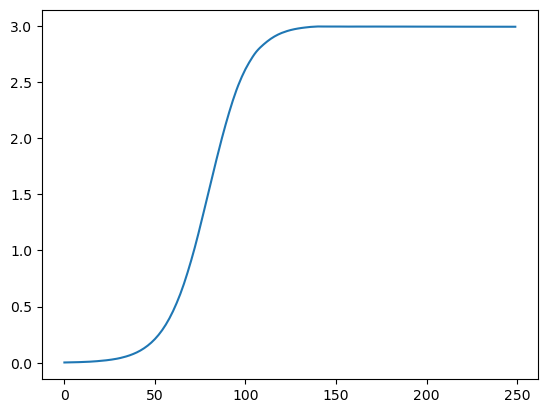

In [22]:
df.loc[:,'LAI_wheat'].plot()

# Stop service

In [ ]:
stop_service(handler)

In [18]:
IFrame(http + '/docs', 800,400)